In [40]:
# Cellule 1: Import des bibliothèques nécessaires
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
# Cellule 2: Sélection et chargement du fichier TIF
# Remplacez ce chemin par votre propre fichier TIF
input_file = r"D:\UQTR\Hiver 2025\Télédétection\TP3\TR_clip.tif"

# Ouvrir le fichier pour l'analyse
src = rasterio.open(input_file)

# Informations sur l'image
print(f"Informations sur l'image {os.path.basename(input_file)}:")
print(f"Dimensions: {src.width} x {src.height} pixels")
print(f"Nombre total de bandes: {src.count}")
print(f"Type de données: {src.dtypes[0]}")
if src.crs:
    print(f"Système de coordonnées: {src.crs.to_string()}")

# Afficher la liste des bandes
print("\nBandes disponibles:")
for i in range(1, src.count + 1):
    desc = src.descriptions[i-1] if src.descriptions and i-1 < len(src.descriptions) else "Non spécifiée"
    print(f"  Bande {i}: {desc}")

Informations sur l'image TR_clip.tif:
Dimensions: 1071 x 637 pixels
Nombre total de bandes: 18
Type de données: float32
Système de coordonnées: EPSG:32618

Bandes disponibles:
  Bande 1: B02_10m
  Bande 2: B03_10m
  Bande 3: B04_10m
  Bande 4: B05_20m
  Bande 5: B06_20m
  Bande 6: B07_20m
  Bande 7: B08_10m
  Bande 8: B11_20m
  Bande 9: B12_20m
  Bande 10: AOT_10m
  Bande 11: WVP_10m
  Bande 12: SCL_20m
  Bande 13: NDVI
  Bande 14: None
  Bande 15: Isodata Unsupervised_1
  Bande 16: Isodata Unsupervised_2
  Bande 17: None
  Bande 18: Isodata Unsupervised


Visualisation des bandes sélectionnées...
Affichage de 12 bandes sur 18 (bandes [10, 14, 15, 16, 17, 18] exclues)


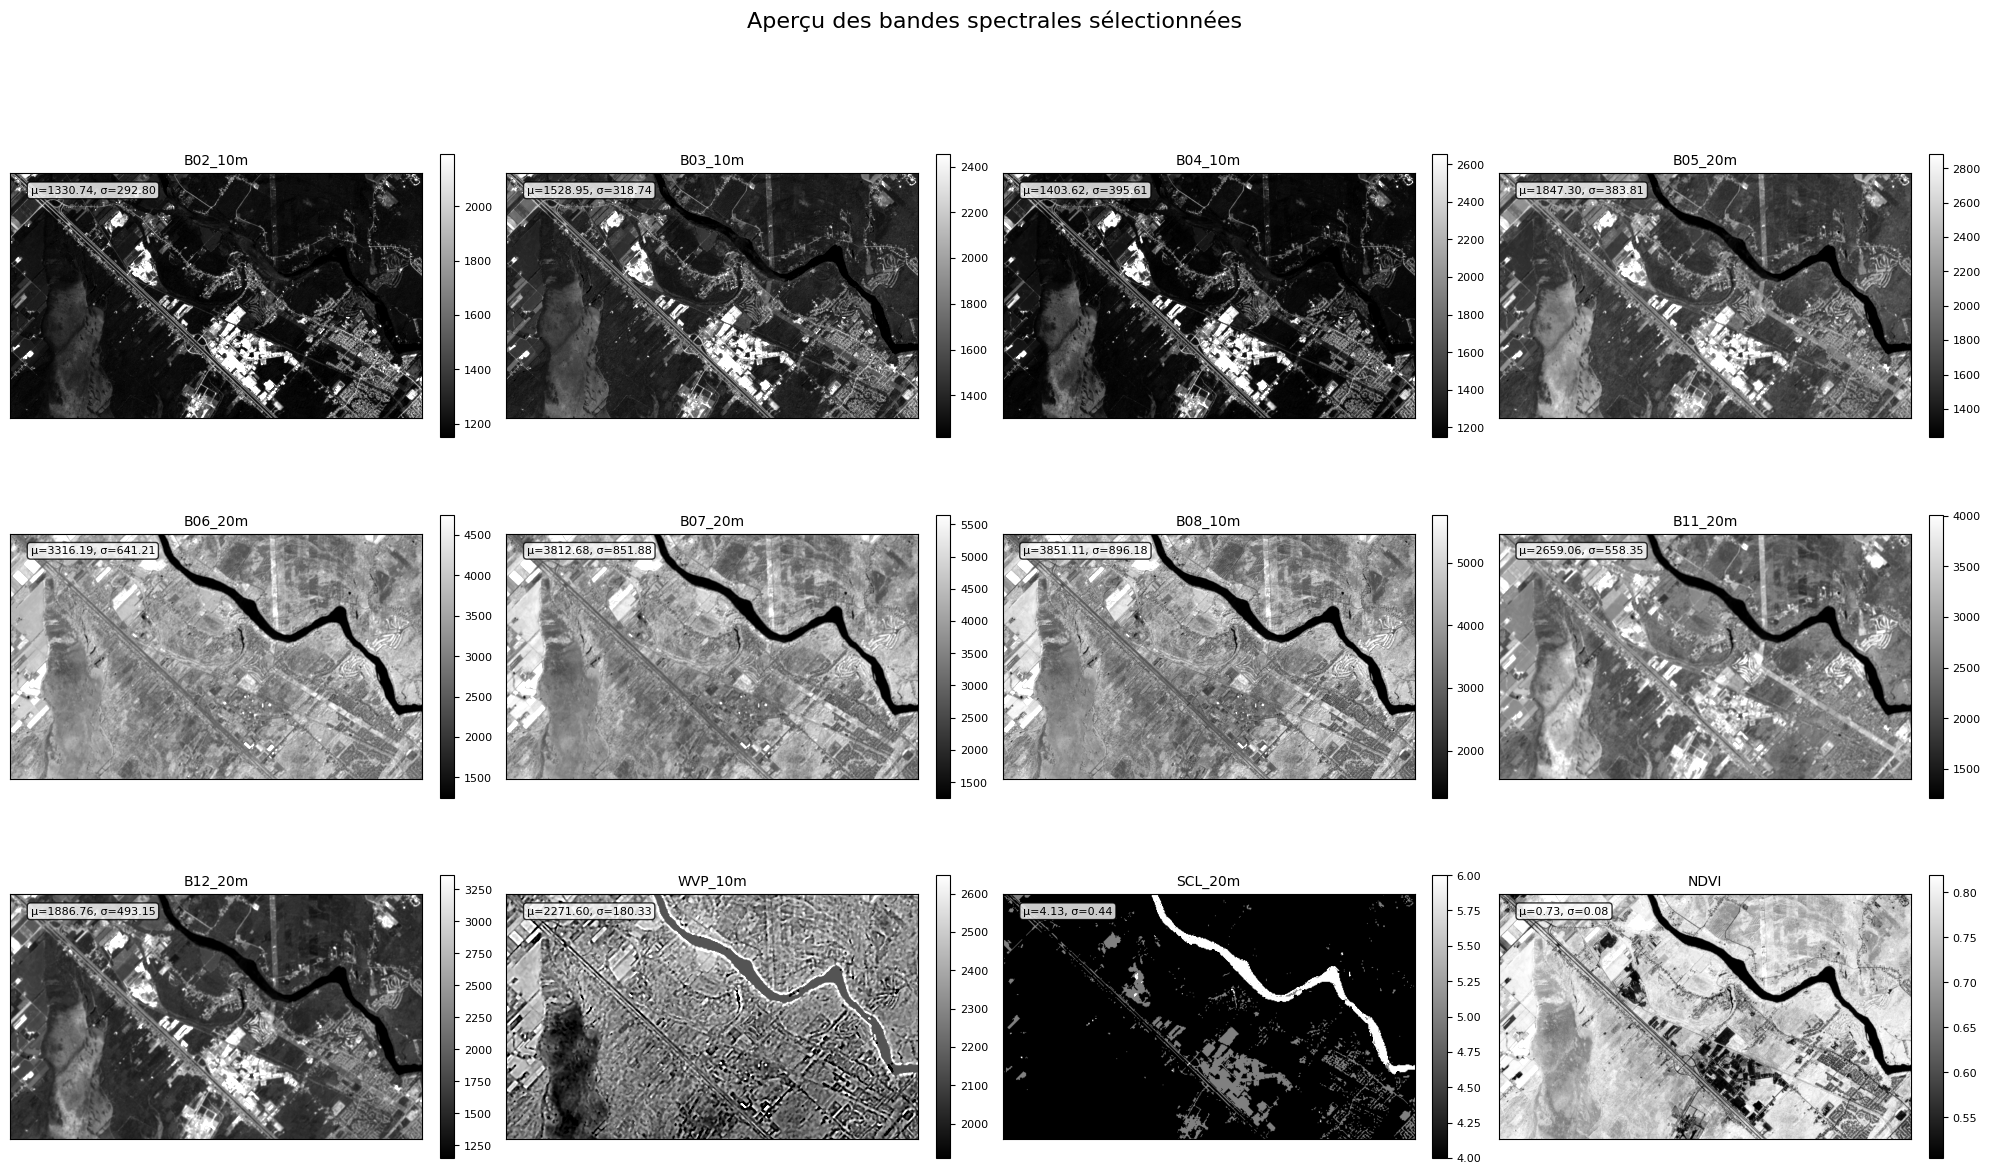

Visualisation des bandes sélectionnées terminée!


In [196]:
# Cellule: Visualisation des bandes sélectionnées avec barres de couleur réduites

print("Visualisation des bandes sélectionnées...")

# Définir les indices de bandes à exclure (indices basés sur 1)
BANDS_TO_EXCLUDE = [10, 14, 15, 16, 17, 18]

# Créer une liste des indices de bandes à afficher (basés sur 1)
bands_to_display = [i+1 for i in range(src.count) if i+1 not in BANDS_TO_EXCLUDE]
n_bands_to_display = len(bands_to_display)

print(f"Affichage de {n_bands_to_display} bandes sur {src.count} (bandes {BANDS_TO_EXCLUDE} exclues)")

# Calculer une disposition de grille adaptée au nombre de bandes
import math
n_cols = min(4, n_bands_to_display)  # Maximum 4 colonnes
n_rows = math.ceil(n_bands_to_display / n_cols)

# Créer la figure avec un layout adapté
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

# Aplatir les axes si plusieurs lignes et colonnes
if n_rows > 1 and n_cols > 1:
    axes = axes.flatten()
elif n_rows == 1 and n_cols > 1:
    axes = axes
elif n_cols == 1 and n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Un seul subplot

# Pour chaque bande sélectionnée, créer un affichage
for idx, band_num in enumerate(bands_to_display):
    # Lire la bande
    band = src.read(band_num)  # band_num est basé sur 1, comme l'API de rasterio
    band_name = src.descriptions[band_num-1] if band_num-1 < len(src.descriptions) else f"Bande {band_num}"
    
    # Supprimer les valeurs NaN/NoData pour l'affichage
    band_display = np.copy(band)
    if src.nodata is not None:
        band_display[band == src.nodata] = np.nan
    
    # Calculer les percentiles pour éviter les outliers
    valid_data = band_display[~np.isnan(band_display)]
    if len(valid_data) > 0:
        vmin, vmax = np.nanpercentile(band_display, [2, 98])
    else:
        vmin, vmax = 0, 1
    
    # Afficher l'image
    im = axes[idx].imshow(band_display, cmap='gray', vmin=vmin, vmax=vmax)
    axes[idx].set_title(f"{band_name}", fontsize=10)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    
    # Ajouter une barre de couleur réduite
    # Modifier ces paramètres pour ajuster la taille de la barre de couleur
    cbar = plt.colorbar(im, ax=axes[idx], fraction=0.035, pad=0.04, shrink=0.7)
    cbar.ax.tick_params(labelsize=8)  # Réduire la taille des étiquettes
    
    # Ajouter des statistiques
    mean_val = np.nanmean(band_display)
    std_val = np.nanstd(band_display)
    axes[idx].text(0.05, 0.95, f"μ={mean_val:.2f}, σ={std_val:.2f}", 
                 transform=axes[idx].transAxes, fontsize=8,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Cacher les subplots vides si le nombre de bandes n'est pas un multiple du nombre de colonnes
for i in range(n_bands_to_display, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Aperçu des bandes spectrales sélectionnées", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.95)  # Ajuster pour faire de la place au titre

# Sauvegarder la figure
output_dir = os.path.join(os.path.dirname(input_file), "output")
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "selected_bands_preview.png"), dpi=300, bbox_inches='tight')

plt.show()

print("Visualisation des bandes sélectionnées terminée!")

In [6]:
# Cellule 5: Fonctions utilitaires pour le traitement
def load_band(image_path, band_index):
    """Charge une bande spécifique de l'image"""
    with rasterio.open(image_path) as src:
        band = src.read(band_index)
        profile = src.profile.copy()
    return band, profile

def save_raster(data, profile, output_path, dtype=None):
    """Sauvegarde un raster au format GeoTIFF"""
    if dtype:
        profile.update(count=1, dtype=dtype, compress='lzw')
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data, 1)
    print(f"Fichier sauvegardé: {output_path}")

In [204]:
# Cellule 7: Classification IsoData avec tous les paramètres

###########################################
#        CONFIGURATION DE L'ANALYSE       #
###########################################

# 1. SÉLECTION DES BANDES
# Indiquez les numéros des bandes à utiliser (basé sur l'affichage des bandes disponibles)
SELECTED_BANDS = [2,4,7,13]

# 2. PARAMÈTRES PRINCIPAUX DE L'ALGORITHME ISODATA
N_CLUSTERS_MIN = 6    # Nombre minimum de clusters
N_CLUSTERS_MAX = 9    # Nombre maximum de clusters
MAX_ITERATIONS = 200   # Nombre maximum d'itérations

# 3. PARAMÈTRES AVANCÉS DE DIVISION/FUSION
MIN_SAMPLES = 40       # Nombre minimum d'échantillons par cluster
MAX_STD_DEV = 0.45      # Écart-type maximum dans un cluster avant division
MIN_DIST = 0.4        # Distance minimale entre clusters pour fusion
MAX_MERGE_PAIRS = 2   # Nombre maximum de paires de clusters à fusionner par itération

# 4. PARAMÈTRES DE CONVERGENCE
CONVERGENCE_THRESHOLD = 0.03  # Seuil de convergence (% de pixels changeant de cluster)

In [241]:

###########################################
#       EXÉCUTION DE LA CLASSIFICATION    #
###########################################

print("Classification non-supervisée avec IsoData...")
print(f"Utilisation de {len(SELECTED_BANDS)} bandes: {SELECTED_BANDS}")

# 1. Chargement des bandes sélectionnées
bands_data = []
band_names = []

for i in SELECTED_BANDS:
    # Lecture de la bande
    band = src.read(i)
    name = src.descriptions[i-1] if i-1 < len(src.descriptions) else f"Bande {i}"
    bands_data.append(band)
    band_names.append(name)
    print(f"  ✓ Bande {i}: {name} chargée")
    
# 2. Vérification et redimensionnement des bandes
reference_shape = bands_data[0].shape
for i, band in enumerate(bands_data):
    if band.shape != reference_shape:
        print(f"  Redimensionnement de '{band_names[i]}' à {reference_shape}")
        from skimage.transform import resize
        bands_data[i] = resize(band, reference_shape, preserve_range=True)

# 3. Création du stack de bandes
stack = np.stack(bands_data)
n_bands, height, width = stack.shape
print(f"Stack de dimensions: {n_bands} bandes x {height} lignes x {width} colonnes")

# 4. Préparation des données pour le clustering
data_for_clustering = stack.reshape(n_bands, -1).T
valid_pixels = ~np.isnan(data_for_clustering).any(axis=1)
valid_data_raw = data_for_clustering[valid_pixels]

# 5. Normalisation des données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
valid_data = scaler.fit_transform(valid_data_raw)
print(f"Données normalisées: {valid_data.shape[0]} pixels valides avec {n_bands} dimensions")

# 6. Initialisation avec KMeans
print(f"Initialisation avec {N_CLUSTERS_MIN} classes...")
kmeans_init = KMeans(
    n_clusters=N_CLUSTERS_MIN, 
    max_iter=10,
    init='k-means++',
    random_state=42,
    n_init='auto'
)
labels = kmeans_init.fit_predict(valid_data)
centers = kmeans_init.cluster_centers_

# 7. Algorithme IsoData
print("Exécution de l'algorithme IsoData...")
iteration = 0
n_clusters_current = N_CLUSTERS_MIN
previous_labels = None
converged = False

while iteration < MAX_ITERATIONS and not converged:
    iteration += 1
    
    # 7.1 Assignation des points aux clusters
    distances = np.sqrt(((valid_data[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    
    # 7.2 Vérification de la convergence
    if previous_labels is not None:
        changes = np.sum(previous_labels != labels)
        change_ratio = changes / len(labels)
        if change_ratio < CONVERGENCE_THRESHOLD:
            print(f"Convergence atteinte à l'itération {iteration} ({change_ratio:.4f} < {CONVERGENCE_THRESHOLD})")
            converged = True
    
    previous_labels = labels.copy()
    
    # 7.3 Vérifier les clusters vides et les recréer si nécessaire
    unique_labels, counts = np.unique(labels, return_counts=True)
    empty_clusters = np.setdiff1d(np.arange(n_clusters_current), unique_labels)
    
    for empty in empty_clusters:
        # Trouver le cluster avec le plus de points et le diviser
        largest_cluster = unique_labels[np.argmax(counts)]
        largest_indices = np.where(labels == largest_cluster)[0]
        
        # Prendre les points les plus éloignés comme nouveau centre
        largest_points = valid_data[largest_indices]
        center_dist = np.sqrt(((largest_points - centers[largest_cluster]) ** 2).sum(axis=1))
        farthest_point = largest_indices[np.argmax(center_dist)]
        centers[empty] = valid_data[farthest_point]
    
    # 7.4 Recalculer les centres
    for i in range(n_clusters_current):
        if i in unique_labels:
            cluster_points = valid_data[labels == i]
            centers[i] = np.mean(cluster_points, axis=0)
    
    # 7.5 Diviser les clusters si nécessaire (variance trop élevée)
    if n_clusters_current < N_CLUSTERS_MAX:
        clusters_to_split = []
        for i in range(n_clusters_current):
            if i not in unique_labels or counts[list(unique_labels).index(i)] < MIN_SAMPLES:
                continue
                
            cluster_points = valid_data[labels == i]
            std_devs = np.std(cluster_points, axis=0)
            
            if np.any(std_devs > MAX_STD_DEV) and n_clusters_current < N_CLUSTERS_MAX:
                clusters_to_split.append((i, std_devs))
        
        # Trier les clusters par écart-type maximal (diviser d'abord les plus variables)
        clusters_to_split.sort(key=lambda x: np.max(x[1]), reverse=True)
        
        # Diviser les clusters
        for i, std_devs in clusters_to_split:
            if n_clusters_current >= N_CLUSTERS_MAX:
                break
                
            # Diviser le cluster selon l'axe à plus grande variance
            max_var_axis = np.argmax(std_devs)
            std_dev = std_devs[max_var_axis]
            
            # Calculer deux nouveaux centres
            centers = np.vstack([centers, centers[i] + np.array([0.5 * std_dev if j == max_var_axis else 0 for j in range(n_bands)])])
            centers[i] = centers[i] - np.array([0.5 * std_dev if j == max_var_axis else 0 for j in range(n_bands)])
            
            n_clusters_current += 1
            print(f"  Cluster {i} divisé selon l'axe {max_var_axis} (std={std_dev:.4f}) → {n_clusters_current} clusters")
    
    # 7.6 Fusionner des clusters si nécessaire (trop proches)
    if n_clusters_current > N_CLUSTERS_MIN:
        center_distances = np.sqrt(((centers[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2).sum(axis=2))
        np.fill_diagonal(center_distances, np.inf)  # Ne pas comparer un cluster avec lui-même
        
        merge_count = 0
        while merge_count < MAX_MERGE_PAIRS and n_clusters_current > N_CLUSTERS_MIN:
            min_dist_idx = np.unravel_index(np.argmin(center_distances), center_distances.shape)
            min_dist_value = center_distances[min_dist_idx]
            
            if min_dist_value > MIN_DIST:
                break  # Pas de clusters assez proches pour fusion
                
            i, j = min_dist_idx
            # Fusionner les clusters i et j
            weights = np.array([counts[list(unique_labels).index(i)] if i in unique_labels else 0, 
                              counts[list(unique_labels).index(j)] if j in unique_labels else 0])
            
            if np.sum(weights) > 0:
                centers[i] = (centers[i] * weights[0] + centers[j] * weights[1]) / np.sum(weights)
                
            # Supprimer le cluster j
            centers = np.delete(centers, j, axis=0)
            labels[labels == j] = i
            labels[labels > j] -= 1  # Réindexer les labels supérieurs
            
            # Mettre à jour le nombre de clusters
            n_clusters_current -= 1
            print(f"  Clusters {i} et {j} fusionnés (distance={min_dist_value:.4f}) → {n_clusters_current} clusters")
            
            # Mettre à jour la matrice de distances
            center_distances = np.sqrt(((centers[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2).sum(axis=2))
            np.fill_diagonal(center_distances, np.inf)
            
            merge_count += 1
    
    print(f"Itération {iteration}: {n_clusters_current} clusters")

# 8. Reconstruction de l'image classifiée finale
clusters = labels
classification = np.zeros(height * width, dtype=np.uint8)
classification[valid_pixels] = clusters + 1  # Classes commencent à 1
classification = classification.reshape(height, width)

# 9. Sauvegarder la classification
output_dir = os.path.join(os.path.dirname(input_file), "output")
os.makedirs(output_dir, exist_ok=True)

class_path = os.path.join(output_dir, "classification_isodata.tif")
profile_out = src.profile.copy()
profile_out.update(count=1, dtype=rasterio.uint8, nodata=0)

with rasterio.open(class_path, 'w', **profile_out) as dst:
    dst.write(classification, 1)

print(f"\nClassification terminée avec {n_clusters_current} classes")
print(f"Résultat sauvegardé dans: {class_path}")

# 10. Afficher des statistiques sur les classes
unique_classes, class_counts = np.unique(classification, return_counts=True)
print("\nStatistiques des classes:")
for i, (cls, count) in enumerate(zip(unique_classes[1:], class_counts[1:])):  # Ignorer la classe 0 (non classé)
    percentage = (count / np.sum(class_counts[1:])) * 100
    print(f"  Classe {cls}: {count} pixels ({percentage:.2f}%)")

Classification non-supervisée avec IsoData...
Utilisation de 4 bandes: [2, 4, 7, 13]
  ✓ Bande 2: B03_10m chargée
  ✓ Bande 4: B05_20m chargée
  ✓ Bande 7: B08_10m chargée
  ✓ Bande 13: NDVI chargée
Stack de dimensions: 4 bandes x 637 lignes x 1071 colonnes
Données normalisées: 682227 pixels valides avec 4 dimensions
Initialisation avec 6 classes...


Exécution de l'algorithme IsoData...
  Cluster 3 divisé selon l'axe 0 (std=2.2005) → 7 clusters
  Cluster 5 divisé selon l'axe 2 (std=0.6321) → 8 clusters
  Cluster 0 divisé selon l'axe 3 (std=0.6291) → 9 clusters
Itération 1: 9 clusters
Itération 2: 9 clusters
Itération 3: 9 clusters
Itération 4: 9 clusters
Itération 5: 9 clusters
Convergence atteinte à l'itération 6 (0.0271 < 0.03)
Itération 6: 9 clusters

Classification terminée avec 9 classes
Résultat sauvegardé dans: D:\UQTR\Hiver 2025\Télédétection\TP3\output\classification_isodata.tif

Statistiques des classes:
  Classe 2: 160566 pixels (25.67%)
  Classe 3: 181497 pixels (29.02%)
  Classe 4: 25797 pixels (4.12%)
  Classe 5: 21104 pixels (3.37%)
  Classe 6: 102358 pixels (16.36%)
  Classe 7: 3952 pixels (0.63%)
  Classe 8: 20430 pixels (3.27%)
  Classe 9: 109823 pixels (17.56%)


In [242]:
# 11. Fusion des classes 4 et 7 pour la carte d'occupation du sol
print("\nCréation d'une version avec fusion des classes 4 et 7 (bâtiments)...")
classification_merged = classification.copy()
classification_merged[classification == 7] = 4

# Sauvegarder la classification fusionnée
class_merged_path = os.path.join(output_dir, "classification_isodata_landcover.tif")
with rasterio.open(class_merged_path, 'w', **profile_out) as dst:
    dst.write(classification_merged, 1)

# Statistiques après fusion
unique_classes_merged, class_counts_merged = np.unique(classification_merged, return_counts=True)
print("\nStatistiques des classes après fusion des bâtiments:")
for i, (cls, count) in enumerate(zip(unique_classes_merged[1:], class_counts_merged[1:])):
    percentage = (count / np.sum(class_counts_merged[1:])) * 100
    class_name = f"{cls}"
    if cls == 4:
        class_name += " (bâtiments fusionnés)"
    print(f"  Classe {class_name}: {count} pixels ({percentage:.2f}%)")

print(f"\nClassification avec fusion sauvegardée dans: {class_merged_path}")


Création d'une version avec fusion des classes 4 et 7 (bâtiments)...

Statistiques des classes après fusion des bâtiments:
  Classe 2: 160566 pixels (25.67%)
  Classe 3: 181497 pixels (29.02%)
  Classe 4 (bâtiments fusionnés): 29749 pixels (4.76%)
  Classe 5: 21104 pixels (3.37%)
  Classe 6: 102358 pixels (16.36%)
  Classe 8: 20430 pixels (3.27%)
  Classe 9: 109823 pixels (17.56%)

Classification avec fusion sauvegardée dans: D:\UQTR\Hiver 2025\Télédétection\TP3\output\classification_isodata_landcover.tif


Fusion des classes 4 et 7...
Nombre de pixels modifiés: 3952
Classes après fusion: [1 2 3 4 5 6 8 9]
Classes valides (> 0): [1, 2, 3, 4, 5, 6, 8, 9]


C:\Users\thier\AppData\Local\Temp\ipykernel_32500\1702386295.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


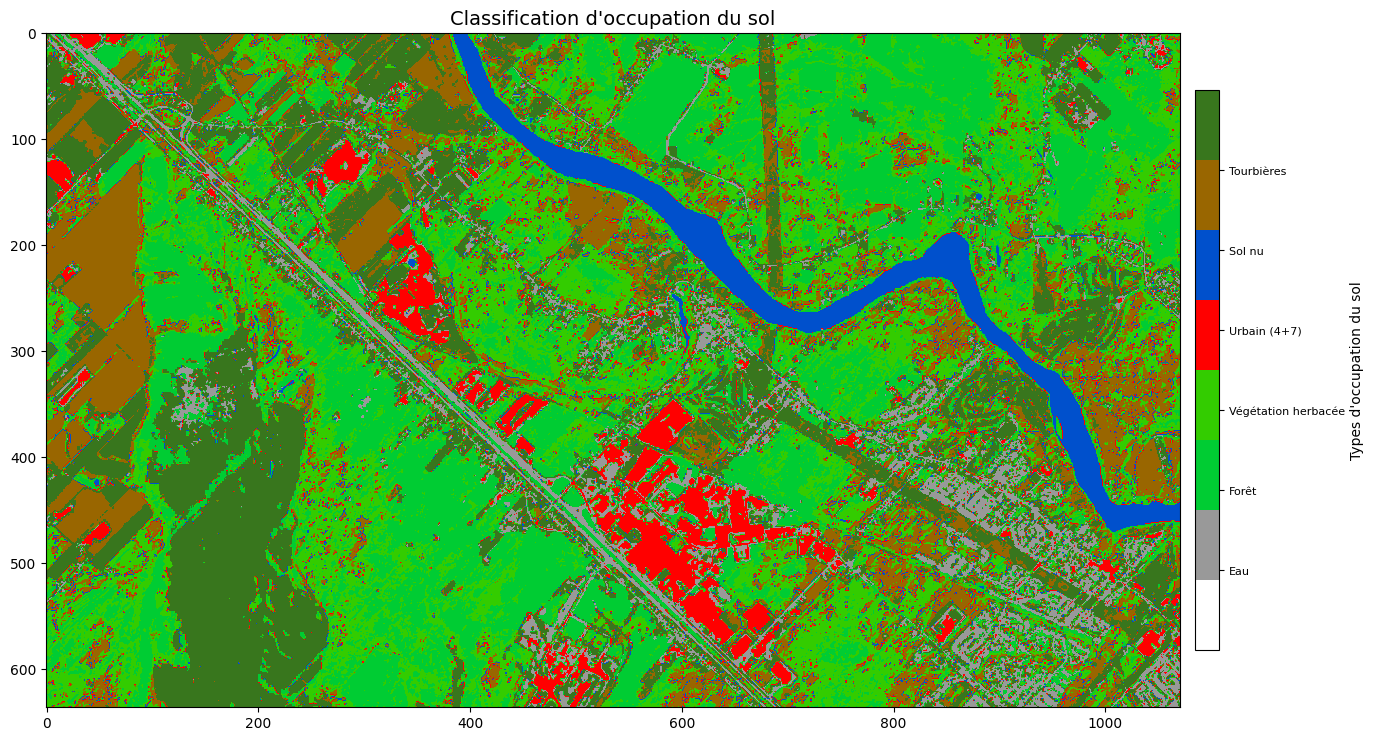


Carte de classification sans classe 0 (noire) générée avec succès!


In [243]:
# Cellule 8: Visualisation des résultats sans la classe noire
print("Fusion des classes 4 et 7...")

# Créer une copie de la classification
classification_fusionnee = classification.copy()

# Remplacer tous les pixels de classe 7 par la classe 4
classification_fusionnee[classification == 7] = 4

print(f"Nombre de pixels modifiés: {np.sum(classification == 7)}")

# Utiliser cette classification fusionnée pour la visualisation
classification = classification_fusionnee

# Recalculer les classes uniques après fusion
unique_classes = np.unique(classification)
num_classes = len(unique_classes)
print(f"Classes après fusion: {unique_classes}")

# Le reste du code de visualisation reste identique
plt.figure(figsize=(12, 8)) # Increased width to have space for colorbar

# Définir des couleurs personnalisées pour chaque classe en format hexadécimal
hex_colors = [
    '#FFFFFF00',  # Classe 0: Transparent (au lieu de noir)
    '#999999',    # Classe 1: Eau
    '#00CC33',    # Classe 2: Forêt
    '#33CC00',    # Classe 3: Végétation herbacée
    '#FF0000',    # Classe 4: Urbain (fusionnée avec 7)
    '#0050CC',    # Classe 5: Sol nu
    '#996600',    # Classe 6: Tourbières
    '#38761d',    # Classe 8: Végétation arbustive
    '#FF6699',    # Classe 9: Milieux humides
]

# S'assurer d'avoir assez de couleurs
if num_classes > len(hex_colors):
    # Générer des couleurs supplémentaires si nécessaire
    import random
    for i in range(len(hex_colors), num_classes):
        random_color = '#%02X%02X%02X' % (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255)
        )
        hex_colors.append(random_color)

# Convertir les codes hexadécimaux en couleurs RGBA pour matplotlib (avec transparence)
from matplotlib.colors import to_rgba, ListedColormap
rgba_colors = [to_rgba(hex_color) for hex_color in hex_colors[:num_classes]]

# Créer une colormap personnalisée avec transparence
custom_cmap = ListedColormap(rgba_colors)

# Filtrer pour obtenir uniquement les classes > 0
valid_classes = [c for c in unique_classes if c > 0]
print(f"Classes valides (> 0): {valid_classes}")

# Définir des noms thématiques pour chaque classe
class_themes = {
    1: "Eau",
    2: "Forêt",
    3: "Végétation herbacée",
    4: "Urbain",
    5: "Sol nu",
    6: "Tourbières",
    8: "Végétation arbustive",
    9: "Milieux humides"
}

# Créer des étiquettes pour les classes valides avec noms thématiques
class_labels = []
for i in valid_classes:
    if i in class_themes:
        if i == 4:
            # Spécifier que c'est une fusion pour la classe 4
            class_labels.append(f"{class_themes[i]} (4+7)")
        else:
            class_labels.append(f"{class_themes[i]}")
    else:
        class_labels.append(f"Classe {i}")

# Afficher la classification avec fond transparent pour la classe 0
plt.title("Classification d'occupation du sol", fontsize=14)

# Ajouter un fond blanc ou une couleur neutre comme base
plt.gca().set_facecolor('#EFEFEF')  # Fond gris très clair

im = plt.imshow(classification, cmap=custom_cmap, vmin=0, vmax=num_classes-1)

# Create a colorbar with labels, positioned outside the plot
cax = plt.axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cax, ticks=valid_classes)  # N'afficher que les ticks des classes valides
cbar.set_label("Types d'occupation du sol", fontsize=10)
cbar.ax.set_yticklabels(class_labels, fontsize=8)

# Ajouter plus d'informations à la carte
plt.axis('on')
plt.grid(False)

# Sauvegarder la figure avec fond transparent
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "classification_sans_classe0.png"), dpi=300, transparent=False)
plt.show()

print("\nCarte de classification sans classe 0 (noire) générée avec succès!")

In [ ]:
# Cellule: Statistiques de la classification IsoData

# Importations nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import metrics

print("Génération des statistiques de classification...")

# 1. Statistiques générales sur les classes
unique_classes, class_counts = np.unique(classification, return_counts=True)
classes_stats = pd.DataFrame({
    'Classe': unique_classes,
    'Nombre de pixels': class_counts,
    'Pourcentage (%)': (class_counts / np.sum(class_counts) * 100).round(2)
})

# Exclure la classe 0 (non classifié) si présente
if 0 in unique_classes:
    valid_pixels_count = np.sum(class_counts) - class_counts[0]
    print(f"Total de pixels classifiés: {valid_pixels_count:,} sur {np.sum(class_counts):,} pixels")
    print(f"Pourcentage classifié: {(valid_pixels_count / np.sum(class_counts) * 100):.2f}%")
    
    # Recalculer les pourcentages sans les pixels non classifiés
    classes_stats_valid = classes_stats[classes_stats['Classe'] > 0].copy()
    classes_stats_valid['Pourcentage valide (%)'] = (classes_stats_valid['Nombre de pixels'] / valid_pixels_count * 100).round(2)

print("\nStatistiques par classe:")
display(classes_stats)

# 2. Visualisation de la distribution des classes
plt.figure(figsize=(10, 6))

# Graphique à barres des classes (exclure la classe 0 si présente)
classes_to_plot = classes_stats[classes_stats['Classe'] > 0] if 0 in unique_classes else classes_stats
plt.bar(classes_to_plot['Classe'], classes_to_plot['Nombre de pixels'], color='steelblue')
plt.xlabel('Classe')
plt.ylabel('Nombre de pixels')
plt.title('Distribution des pixels par classe')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(classes_to_plot['Classe'])

# Ajouter les étiquettes de pourcentage sur chaque barre
for i, (classe, count, pct) in enumerate(zip(
    classes_to_plot['Classe'], 
    classes_to_plot['Nombre de pixels'],
    classes_to_plot['Pourcentage (%)']
)):
    plt.text(classe, count + (max(classes_to_plot['Nombre de pixels']) * 0.02), 
             f"{pct}%", ha='center')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "classes_distribution.png"), dpi=300)
plt.show()

# 3. Statistiques spectrales par classe (si les bandes sont disponibles)
try:
    # Récupérer les données des bandes utilisées pour la classification
    band_names = [src.descriptions[i-1] if i-1 < len(src.descriptions) else f"Bande {i}" for i in SELECTED_BANDS]
    
    # Créer un dataframe pour les statistiques spectrales
    spectral_stats = []
    
    # Pour chaque classe, calculer les moyennes et écarts-types des bandes
    for class_id in unique_classes:
        if class_id == 0:  # Ignorer la classe non classifiée
            continue
            
        # Masque pour cette classe
        class_mask = (classification == class_id)
        
        # Calculer les statistiques pour chaque bande
        for band_idx, band_name in zip(SELECTED_BANDS, band_names):
            band_data = src.read(band_idx)
            
            # Statistiques de la bande pour cette classe
            band_values = band_data[class_mask]
            band_mean = np.nanmean(band_values)
            band_std = np.nanstd(band_values)
            
            spectral_stats.append({
                'Classe': class_id,
                'Bande': band_name,
                'Moyenne': round(float(band_mean), 4),
                'Écart-type': round(float(band_std), 4),
                'Min': round(float(np.nanmin(band_values)), 4),
                'Max': round(float(np.nanmax(band_values)), 4)
            })
    
    # Créer le DataFrame des statistiques spectrales
    spectral_df = pd.DataFrame(spectral_stats)
    
    print("\nStatistiques spectrales par classe:")
    display(spectral_df)
    
    # Pivot table pour mieux visualiser les moyennes par classe et par bande
    pivot_means = spectral_df.pivot(index='Classe', columns='Bande', values='Moyenne')
    print("\nMoyennes spectrales par classe:")
    display(pivot_means)
    
    # Visualisation des signatures spectrales
    plt.figure(figsize=(12, 8))
    
    # Pour chaque classe, tracer la signature spectrale moyenne
    for class_id in unique_classes:
        if class_id == 0:  # Ignorer la classe non classifiée
            continue
        
        class_data = spectral_df[spectral_df['Classe'] == class_id]
        plt.plot(class_data['Bande'], class_data['Moyenne'], 'o-', label=f"Classe {class_id}")
    
    plt.title("Signatures spectrales moyennes par classe")
    plt.xlabel("Bande spectrale")
    plt.ylabel("Valeur moyenne")
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "signatures_spectrales.png"), dpi=300)
    plt.show()
    
except Exception as e:
    print(f"Impossible de calculer les statistiques spectrales: {e}")

# 4. Indices de validation du clustering
print("\nCalcul des indices de validation du clustering...")
try:
    # Reformater pour le calcul des métriques
    data_for_metrics = stack.reshape(n_bands, -1).T
    valid_pixels = ~np.isnan(data_for_metrics).any(axis=1)
    valid_data = data_for_metrics[valid_pixels]
    valid_labels = classification.flatten()[valid_pixels]
    
    # Calculer les indices de validation uniquement pour les pixels classifiés
    if 0 in unique_classes:
        valid_indices = valid_labels > 0
        metrics_data = valid_data[valid_indices]
        metrics_labels = valid_labels[valid_indices]
    else:
        metrics_data = valid_data
        metrics_labels = valid_labels
    
    # Vérifier que chaque cluster a suffisamment d'échantillons
    min_samples_per_class = 10  # Minimum requis pour l'indice de silhouette
    unique_labels, label_counts = np.unique(metrics_labels, return_counts=True)
    small_clusters = [label for label, count in zip(unique_labels, label_counts) if count < min_samples_per_class]
    
    if len(small_clusters) > 0:
        print(f"Attention: {len(small_clusters)} classes ont moins de {min_samples_per_class} pixels, ce qui peut affecter les métriques de validation.")
        for cluster in small_clusters:
            print(f"  Classe {cluster}: {label_counts[list(unique_labels).index(cluster)]} pixels")
    
    # Calculer l'indice de Calinski-Harabasz
    try:
        calinski_harabasz = metrics.calinski_harabasz_score(metrics_data, metrics_labels)
        print(f"Indice de Calinski-Harabasz: {calinski_harabasz:.4f}")
        print("(Une valeur plus élevée indique une meilleure définition des clusters)")
    except Exception as e:
        print(f"Impossible de calculer l'indice de Calinski-Harabasz: {e}")
    
    # Calculer l'indice de Davies-Bouldin
    try:
        davies_bouldin = metrics.davies_bouldin_score(metrics_data, metrics_labels)
        print(f"Indice de Davies-Bouldin: {davies_bouldin:.4f}")
        print("(Une valeur plus proche de zéro indique une meilleure séparation des clusters)")
    except Exception as e:
        print(f"Impossible de calculer l'indice de Davies-Bouldin: {e}")
    
    # Calculer l'indice de silhouette si possible (pour un échantillon si les données sont trop volumineuses)
    try:
        # Si les données sont trop volumineuses, échantillonner pour le calcul de silhouette
        max_samples_for_silhouette = 10000  # Pour éviter les problèmes de mémoire
        
        if metrics_data.shape[0] > max_samples_for_silhouette:
            print(f"Échantillonnage de {max_samples_for_silhouette} pixels sur {metrics_data.shape[0]} pour le calcul de silhouette...")
            # Échantillonnage stratifié pour conserver la distribution des classes
            from sklearn.model_selection import StratifiedShuffleSplit
            
            sss = StratifiedShuffleSplit(n_splits=1, test_size=max_samples_for_silhouette, random_state=42)
            _, sample_indices = next(sss.split(metrics_data, metrics_labels))
            
            silhouette_data = metrics_data[sample_indices]
            silhouette_labels = metrics_labels[sample_indices]
        else:
            silhouette_data = metrics_data
            silhouette_labels = metrics_labels
        
        # Vérifier que tous les clusters ont au moins 2 échantillons
        unique_labels, counts = np.unique(silhouette_labels, return_counts=True)
        has_single_samples = np.any(counts < 2)
        
        if not has_single_samples:
            silhouette_avg = metrics.silhouette_score(silhouette_data, silhouette_labels)
            print(f"Indice de silhouette moyen: {silhouette_avg:.4f}")
            print("(Une valeur proche de 1 indique une bonne séparation des clusters)")
        else:
            print("Impossible de calculer l'indice de silhouette: certaines classes n'ont qu'un seul élément.")
    
    except Exception as e:
        print(f"Impossible de calculer l'indice de silhouette: {e}")

except Exception as e:
    print(f"Impossible de calculer les indices de validation: {e}")

# 5. Exporter les statistiques en CSV
try:
    # Statistiques des classes
    classes_stats.to_csv(os.path.join(output_dir, "classes_statistics.csv"), index=False)
    
    # Statistiques spectrales
    if 'spectral_df' in locals():
        spectral_df.to_csv(os.path.join(output_dir, "spectral_statistics.csv"), index=False)
        
    print(f"\nStatistiques exportées dans {output_dir}")
except Exception as e:
    print(f"Erreur lors de l'exportation des statistiques: {e}")

print("\nAnalyse des statistiques de classification terminée.")

Calcul des statistiques complémentaires...

1. Analyse de la séparabilité des classes
Matrice de distances euclidiennes entre centroïdes des classes:


,Classe 1,Classe 2,Classe 3,Classe 4,Classe 5,Classe 6,Classe 8,Classe 9
Classe 1,0.000000,675.087524,424.491760,1277.358276,1303.729004,2634.514648,682.095642,587.448364
Classe 2,675.087524,0.000000,698.245117,1318.425537,1887.135986,2284.902588,932.355164,822.397705
Classe 3,424.491760,698.245117,0.000000,1630.706177,1230.123413,2290.188965,294.367065,956.553589
Classe 4,1277.358276,1318.425537,1630.706177,0.000000,2262.922607,3598.951172,1849.541626,691.922974
Classe 5,1303.729004,1887.135986,1230.123413,2262.922607,0.000000,3140.687988,1096.036255,1669.816650
Classe 6,2634.514648,2284.902588,2290.188965,3598.951172,3140.687988,0.000000,2238.464844,3066.393799
Classe 8,682.095642,932.355164,294.367065,1849.541626,1096.036255,2238.464844,0.000000,1185.924072
Classe 9,587.448364,822.397705,956.553589,691.922974,1669.816650,3066.393799,1185.924072,0.000000


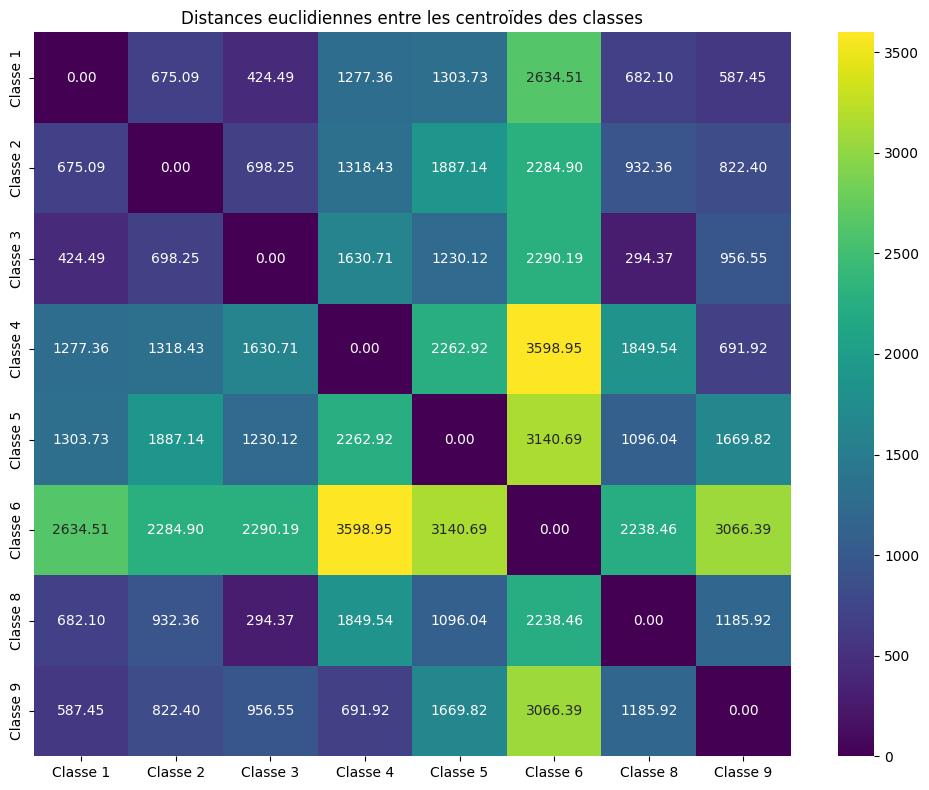

Distance minimale entre deux classes: 294.3671
Distance maximale entre deux classes: 3598.9512
Distance moyenne entre les classes: 1526.0996
Classes les plus similaires: Classe 3 et Classe 8
Classes les plus différentes: Classe 4 et Classe 6

2. Analyse de la variance intra-classe vs inter-classe
Variance intra-classe par classe:


,Classe,Variance intra-classe
3,4,572745.25000
4,5,436651.37500
7,9,302135.75000
6,8,281567.56250
2,3,270302.68750
0,1,232521.50000
1,2,166188.15625
5,6,50485.06250


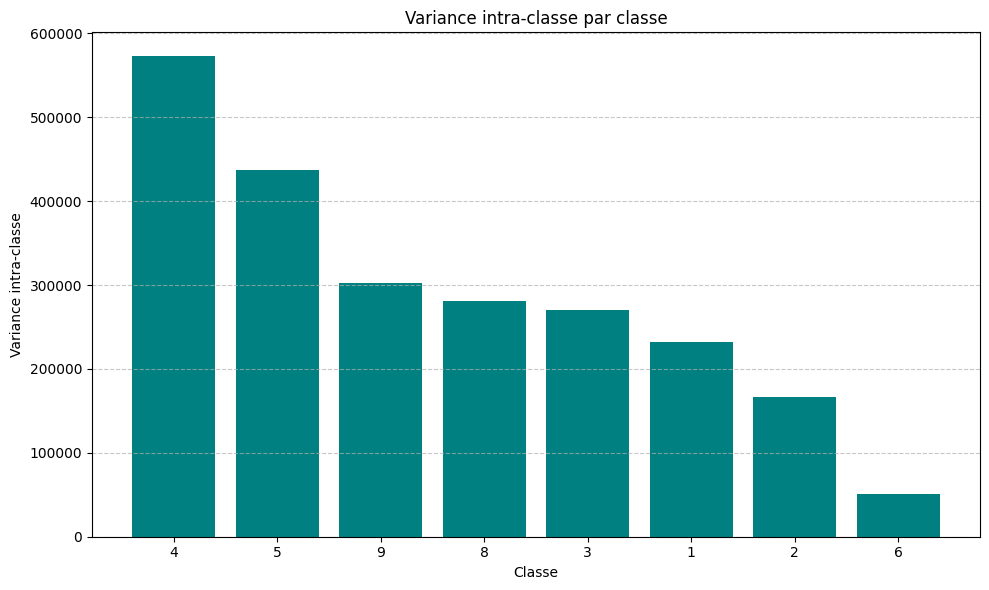


Ratio de Fisher (variance inter-classe / variance intra-classe) pour les paires de classes:


,Classe 1,Classe 2,Ratio de Fisher
26,6,9,26.665386
4,1,6,24.524755
10,2,6,24.095177
19,4,6,20.782766
22,5,6,20.248783
15,3,6,16.350267
25,6,8,15.090154
9,2,5,5.907513
18,4,5,5.073149
20,4,8,4.004159


Ratio de Fisher moyen: 6.8810
Ratio de Fisher médian: 2.3809

3. Analyse spatiale des clusters
Statistiques spatiales par classe:


,Classe,Nombre de pixels,Nombre de régions,Taille moyenne des régions,Taille médiane des régions,Plus grande région (pixels),Plus petite région (pixels),Fragmentation (régions/pixels)
1,2,235988,5004,47.159872,2.0,50049,1,0.021204
3,4,185166,4893,37.843041,2.0,27488,1,0.026425
7,9,87169,9127,9.550674,2.0,4213,1,0.104705
0,1,57688,9297,6.205012,1.0,29482,1,0.161160
2,3,45644,5248,8.697409,2.0,1088,1,0.114977
6,8,29829,4478,6.661233,2.0,3155,1,0.150122
5,6,21020,77,272.987013,2.0,20301,1,0.003663
4,5,19723,412,47.871359,4.0,2698,1,0.020889


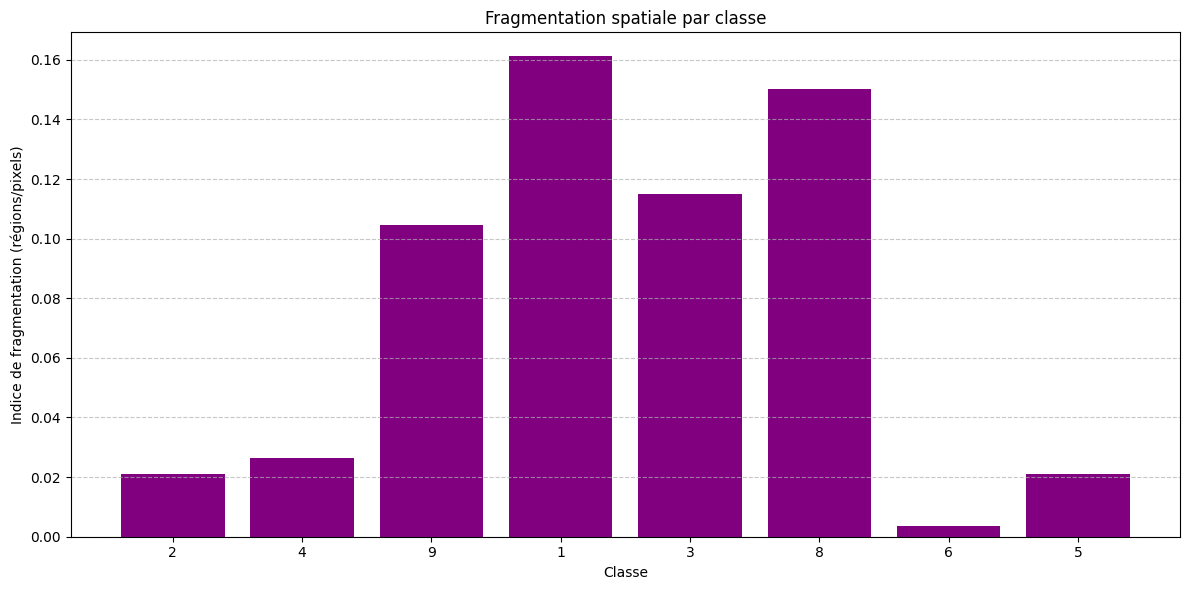


4. Visualisation des classes dans l'espace ACP
Variance expliquée: PC1 = 72.43%, PC2 = 26.53%


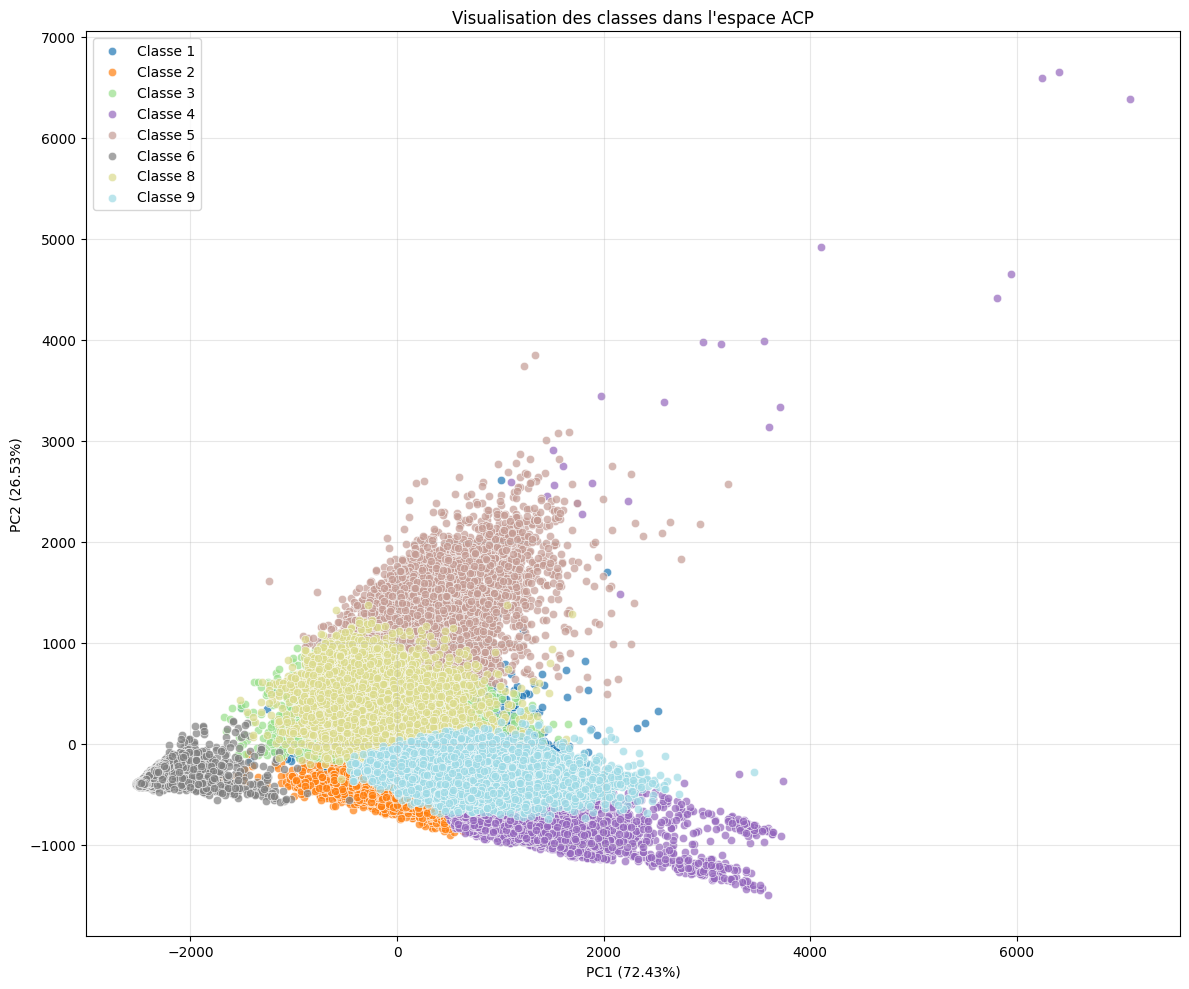


Séparation des classes dans l'espace ACP:


,Classe 1,Classe 2,Distance moyenne dans l'espace ACP
19,4,6,3635.481689
22,5,6,3143.237061
26,6,9,3082.065186
4,1,6,2634.672852
18,4,5,2396.626221
15,3,6,2341.360107
10,2,6,2289.858398
25,6,8,2264.543457
9,2,5,1983.904785
20,4,8,1907.639893



5. Indices d'homogénéité et d'entropie
Entropie de Shannon par classe (mesure d'homogénéité):


,Classe,Entropie de Shannon,Nombre de pixels,Entropie normalisée
4,5,3.465260,19723,0.885797
7,9,3.357230,87169,0.858183
2,3,3.329100,45644,0.850992
0,1,3.197754,57688,0.817417
6,8,2.845642,29829,0.727409
1,2,2.766044,235988,0.707062
5,6,2.685362,21020,0.686438
3,4,0.979163,185166,0.250296


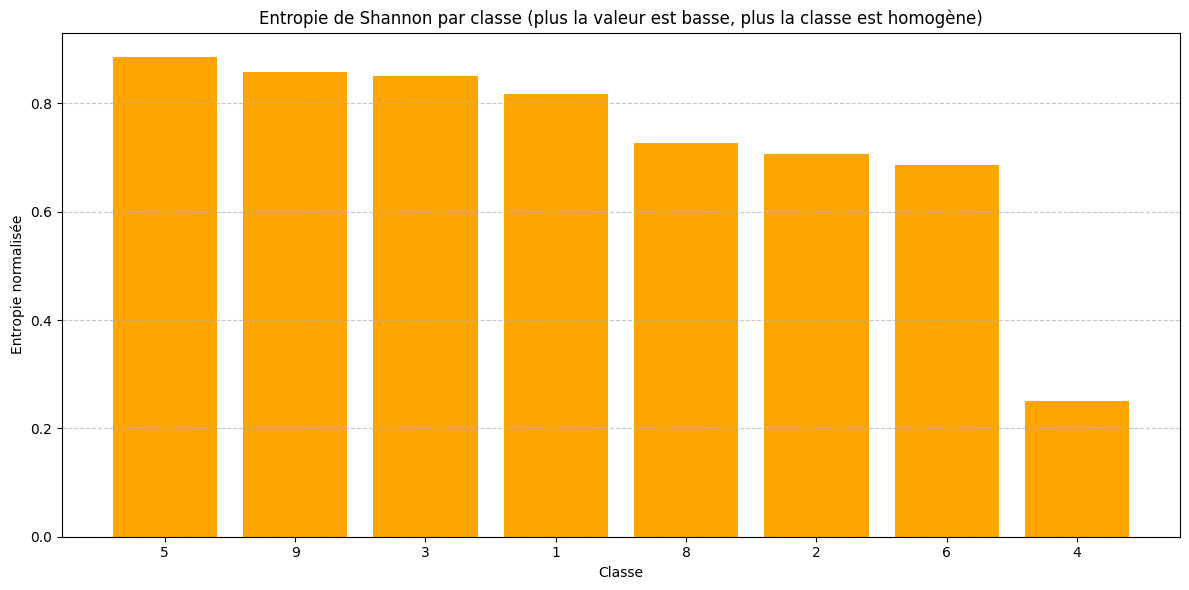


Statistiques complémentaires exportées dans D:\UQTR\Hiver 2025\Télédétection\TP3\output

Analyse des statistiques complémentaires terminée.


In [240]:
# Statistiques complémentaires pour la classification IsoData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.spatial import distance
from scipy.stats import entropy
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import label, generate_binary_structure

print("Calcul des statistiques complémentaires...")

#------------------------------------------------------
# 1. Matrice de séparabilité entre classes
#------------------------------------------------------
print("\n1. Analyse de la séparabilité des classes")

# Calculer les centroïdes de chaque classe
centroids = {}
for class_id in unique_classes:
    if class_id == 0:  # Ignorer la classe non classifiée
        continue
        
    # Masque pour cette classe
    class_mask = (classification == class_id)
    
    # Extraire les données pour cette classe
    class_data = np.array([src.read(band_idx)[class_mask] for band_idx in SELECTED_BANDS])
    
    # Calculer le centroïde (moyenne par bande)
    centroids[class_id] = np.nanmean(class_data, axis=1)

# Calculer la matrice de distances entre centroïdes
class_ids = [c for c in unique_classes if c > 0]
n_classes = len(class_ids)
distance_matrix = np.zeros((n_classes, n_classes))

for i, class1 in enumerate(class_ids):
    for j, class2 in enumerate(class_ids):
        if i != j:
            # Distance euclidienne entre les centroïdes
            distance_matrix[i, j] = distance.euclidean(centroids[class1], centroids[class2])

# Créer un DataFrame pour la matrice de distances
distance_df = pd.DataFrame(distance_matrix, 
                         index=[f'Classe {c}' for c in class_ids],
                         columns=[f'Classe {c}' for c in class_ids])

print("Matrice de distances euclidiennes entre centroïdes des classes:")
display(distance_df)

# Visualiser la matrice de distances sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, annot=True, cmap='viridis', fmt='.2f')
plt.title('Distances euclidiennes entre les centroïdes des classes')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "distances_centroids.png"), dpi=300)
plt.show()

# Calculer les distances minimales, maximales et moyennes
min_distances = []
for i in range(n_classes):
    # Exclure la diagonale (distance à soi-même)
    non_zero_distances = distance_matrix[i, :][distance_matrix[i, :] > 0]
    if len(non_zero_distances) > 0:
        min_distances.append(np.min(non_zero_distances))

print(f"Distance minimale entre deux classes: {np.min(min_distances):.4f}")
print(f"Distance maximale entre deux classes: {np.max(distance_matrix):.4f}")
print(f"Distance moyenne entre les classes: {np.mean(distance_matrix[distance_matrix > 0]):.4f}")

# Identifier les paires de classes les plus proches
min_dist_idx = np.where(distance_matrix == np.min(min_distances))
print(f"Classes les plus similaires: Classe {class_ids[min_dist_idx[0][0]]} et Classe {class_ids[min_dist_idx[1][0]]}")

# Identifier les paires de classes les plus éloignées
max_dist_idx = np.where(distance_matrix == np.max(distance_matrix))
print(f"Classes les plus différentes: Classe {class_ids[max_dist_idx[0][0]]} et Classe {class_ids[max_dist_idx[1][0]]}")

#------------------------------------------------------
# 2. Analyse de la variance intra-classe vs inter-classe
#------------------------------------------------------
print("\n2. Analyse de la variance intra-classe vs inter-classe")

# Calculer la variance intra-classe pour chaque classe
intra_class_variance = {}
for class_id in class_ids:
    # Masque pour cette classe
    class_mask = (classification == class_id)
    
    # Extraire les données pour cette classe
    class_data = np.array([src.read(band_idx)[class_mask] for band_idx in SELECTED_BANDS])
    class_data = class_data.reshape(len(SELECTED_BANDS), -1).T  # Reshape pour faciliter le calcul
    
    # Calculer la variance pour chaque bande
    var_by_band = np.nanvar(class_data, axis=0)
    
    # Variance totale (somme des variances par bande)
    intra_class_variance[class_id] = np.sum(var_by_band)

# Créer un DataFrame pour les variances intra-classe
var_df = pd.DataFrame({
    'Classe': list(intra_class_variance.keys()),
    'Variance intra-classe': list(intra_class_variance.values())
})
var_df = var_df.sort_values('Variance intra-classe', ascending=False)

print("Variance intra-classe par classe:")
display(var_df)

# Visualiser la variance intra-classe
plt.figure(figsize=(10, 6))
plt.bar(var_df['Classe'].astype(str), var_df['Variance intra-classe'], color='teal')
plt.xlabel('Classe')
plt.ylabel('Variance intra-classe')
plt.title('Variance intra-classe par classe')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "variance_intra_classe.png"), dpi=300)
plt.show()

# Calculer le ratio variance inter-classe / variance intra-classe (Fisher)
# Pour chaque paire de classes
fisher_ratios = []
class_pairs = []

for i, class1 in enumerate(class_ids):
    for j, class2 in enumerate(class_ids):
        if i < j:  # Pour éviter de calculer deux fois la même paire
            # Distance entre les moyennes (variance inter-classe)
            inter_var = np.sum((centroids[class1] - centroids[class2])**2)
            
            # Somme des variances intra-classe
            intra_var = intra_class_variance[class1] + intra_class_variance[class2]
            
            # Ratio de Fisher
            if intra_var > 0:
                fisher_ratio = inter_var / intra_var
                fisher_ratios.append(fisher_ratio)
                class_pairs.append((class1, class2))

# Créer un DataFrame pour les ratios de Fisher
fisher_df = pd.DataFrame({
    'Classe 1': [pair[0] for pair in class_pairs],
    'Classe 2': [pair[1] for pair in class_pairs],
    'Ratio de Fisher': fisher_ratios
})
fisher_df = fisher_df.sort_values('Ratio de Fisher', ascending=False)

print("\nRatio de Fisher (variance inter-classe / variance intra-classe) pour les paires de classes:")
display(fisher_df.head(10))  # Afficher les 10 premières paires

print(f"Ratio de Fisher moyen: {np.mean(fisher_ratios):.4f}")
print(f"Ratio de Fisher médian: {np.median(fisher_ratios):.4f}")

#------------------------------------------------------
# 3. Analyse spatiale des clusters
#------------------------------------------------------
print("\n3. Analyse spatiale des clusters")

# Créer une structure pour la recherche de composantes connectées
structure = generate_binary_structure(2, 2)  # Connectivité à 8 voisins

# Statistiques spatiales par classe
spatial_stats = []

for class_id in class_ids:
    # Créer un masque binaire pour cette classe
    class_mask = (classification == class_id).astype(np.int32)
    
    # Identifier les composantes connectées
    labeled_array, num_features = label(class_mask, structure=structure)
    
    # Calculer la superficie de chaque composante (en pixels)
    component_sizes = np.bincount(labeled_array.flatten())[1:]  # Exclure l'arrière-plan (0)
    
    # Statistiques sur les composantes
    spatial_stats.append({
        'Classe': class_id,
        'Nombre de pixels': np.sum(class_mask),
        'Nombre de régions': num_features,
        'Taille moyenne des régions': np.mean(component_sizes) if num_features > 0 else 0,
        'Taille médiane des régions': np.median(component_sizes) if num_features > 0 else 0,
        'Plus grande région (pixels)': np.max(component_sizes) if num_features > 0 else 0,
        'Plus petite région (pixels)': np.min(component_sizes) if num_features > 0 else 0,
        'Fragmentation (régions/pixels)': num_features / np.sum(class_mask) if np.sum(class_mask) > 0 else 0
    })

# Créer un DataFrame pour les statistiques spatiales
spatial_df = pd.DataFrame(spatial_stats)
spatial_df = spatial_df.sort_values('Nombre de pixels', ascending=False)

print("Statistiques spatiales par classe:")
display(spatial_df)

# Visualiser la fragmentation des classes
plt.figure(figsize=(12, 6))
plt.bar(spatial_df['Classe'].astype(str), spatial_df['Fragmentation (régions/pixels)'], color='purple')
plt.xlabel('Classe')
plt.ylabel('Indice de fragmentation (régions/pixels)')
plt.title('Fragmentation spatiale par classe')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "fragmentation_spatiale.png"), dpi=300)
plt.show()

#------------------------------------------------------
# 4. Visualisation avancée avec ACP
#------------------------------------------------------
print("\n4. Visualisation des classes dans l'espace ACP")

# Préparer les données pour l'ACP
data_for_pca = []
labels_for_pca = []

# Échantillonner les pixels pour chaque classe
max_samples_per_class = 5000  # Limiter le nombre d'échantillons par classe pour la visualisation
for class_id in class_ids:
    # Masque pour cette classe
    class_mask = (classification == class_id)
    
    # Extraire les données pour cette classe
    class_data = np.array([src.read(band_idx)[class_mask] for band_idx in SELECTED_BANDS])
    class_data = class_data.reshape(len(SELECTED_BANDS), -1).T  # Reshape pour faciliter le calcul
    
    # Filtrer les pixels contenant des NaN
    valid_indices = ~np.isnan(class_data).any(axis=1)
    valid_data = class_data[valid_indices]
    
    # Échantillonner (si nécessaire)
    if valid_data.shape[0] > max_samples_per_class:
        sample_indices = np.random.choice(valid_data.shape[0], max_samples_per_class, replace=False)
        valid_data = valid_data[sample_indices]
    
    # Ajouter aux données pour l'ACP
    data_for_pca.append(valid_data)
    labels_for_pca.extend([class_id] * valid_data.shape[0])

# Combiner les données de toutes les classes
if data_for_pca:
    all_data = np.vstack(data_for_pca)
    labels = np.array(labels_for_pca)
    
    # Appliquer l'ACP
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(all_data)
    
    # Créer un DataFrame pour la visualisation
    pca_df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'Classe': labels
    })
    
    # Variance expliquée
    explained_variance = pca.explained_variance_ratio_ * 100
    print(f"Variance expliquée: PC1 = {explained_variance[0]:.2f}%, PC2 = {explained_variance[1]:.2f}%")
    
    # Visualiser les résultats de l'ACP
    plt.figure(figsize=(12, 10))
    
    # Utiliser une palette de couleurs distincte
    n_classes = len(class_ids)
    colors = plt.cm.tab20(np.linspace(0, 1, n_classes))
    
    # Tracer les points par classe
    for i, class_id in enumerate(class_ids):
        class_data = pca_df[pca_df['Classe'] == class_id]
        plt.scatter(class_data['PC1'], class_data['PC2'], c=[colors[i]], 
                    label=f'Classe {class_id}', alpha=0.7, edgecolors='w', linewidth=0.5)
    
    plt.xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
    plt.title('Visualisation des classes dans l\'espace ACP')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "classes_acp.png"), dpi=300)
    plt.show()
    
    # Calculer la séparation des classes dans l'espace ACP
    class_separations = []
    for i, class1 in enumerate(class_ids):
        for j, class2 in enumerate(class_ids):
            if i < j:  # Pour éviter de calculer deux fois la même paire
                # Données ACP pour chaque classe
                data1 = pca_df[pca_df['Classe'] == class1][['PC1', 'PC2']].values
                data2 = pca_df[pca_df['Classe'] == class2][['PC1', 'PC2']].values
                
                # Calculer la distance moyenne entre les points des deux classes
                if len(data1) > 0 and len(data2) > 0:
                    # Échantillonner si trop de points pour éviter des calculs trop lourds
                    max_points = 1000
                    if len(data1) > max_points:
                        indices = np.random.choice(len(data1), max_points, replace=False)
                        data1 = data1[indices]
                    if len(data2) > max_points:
                        indices = np.random.choice(len(data2), max_points, replace=False)
                        data2 = data2[indices]
                    
                    # Calcul des distances
                    distances = pairwise_distances(data1, data2)
                    avg_distance = np.mean(distances)
                    
                    class_separations.append({
                        'Classe 1': class1,
                        'Classe 2': class2,
                        'Distance moyenne dans l\'espace ACP': avg_distance
                    })
    
    # Créer un DataFrame pour les séparations de classes
    separation_df = pd.DataFrame(class_separations)
    separation_df = separation_df.sort_values('Distance moyenne dans l\'espace ACP', ascending=False)
    
    print("\nSéparation des classes dans l'espace ACP:")
    display(separation_df)
else:
    print("Pas assez de données valides pour effectuer l'ACP.")

#------------------------------------------------------
# 5. Indice de confusion et d'homogénéité de Shannon
#------------------------------------------------------
print("\n5. Indices d'homogénéité et d'entropie")

# Calculer l'entropie de Shannon pour chaque classe
shannon_entropy = []

for class_id in class_ids:
    # Masque pour cette classe
    class_mask = (classification == class_id)
    
    # Extraire les données pour cette classe (par exemple la première bande)
    band_data = src.read(SELECTED_BANDS[0])[class_mask]
    
    # Discrétiser les valeurs (pour l'entropie)
    bins = 50  # Nombre de bins pour l'histogramme
    hist, _ = np.histogram(band_data, bins=bins)
    
    # Normaliser l'histogramme pour obtenir des probabilités
    prob = hist / np.sum(hist)
    
    # Calculer l'entropie (ignorer les bins vides)
    class_entropy = entropy(prob[prob > 0])
    
    shannon_entropy.append({
        'Classe': class_id,
        'Entropie de Shannon': class_entropy,
        'Nombre de pixels': np.sum(class_mask)
    })

# Créer un DataFrame pour l'entropie
entropy_df = pd.DataFrame(shannon_entropy)
entropy_df['Entropie normalisée'] = entropy_df['Entropie de Shannon'] / np.log(bins)
entropy_df = entropy_df.sort_values('Entropie normalisée', ascending=False)

print("Entropie de Shannon par classe (mesure d'homogénéité):")
display(entropy_df)

# Visualiser l'entropie par classe
plt.figure(figsize=(12, 6))
plt.bar(entropy_df['Classe'].astype(str), entropy_df['Entropie normalisée'], color='orange')
plt.xlabel('Classe')
plt.ylabel('Entropie normalisée')
plt.title('Entropie de Shannon par classe (plus la valeur est basse, plus la classe est homogène)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "entropie_classes.png"), dpi=300)
plt.show()

#------------------------------------------------------
# Exportation des résultats
#------------------------------------------------------
# Exporter les statistiques en CSV
try:
    # Matrice de distances
    distance_df.to_csv(os.path.join(output_dir, "distance_matrix.csv"))
    
    # Variance intra-classe
    var_df.to_csv(os.path.join(output_dir, "intra_class_variance.csv"), index=False)
    
    # Ratios de Fisher
    fisher_df.to_csv(os.path.join(output_dir, "fisher_ratios.csv"), index=False)
    
    # Statistiques spatiales
    spatial_df.to_csv(os.path.join(output_dir, "spatial_statistics.csv"), index=False)
    
    # Entropie
    entropy_df.to_csv(os.path.join(output_dir, "entropy_statistics.csv"), index=False)
    
    if 'separation_df' in locals():
        # Séparation ACP
        separation_df.to_csv(os.path.join(output_dir, "acp_separation.csv"), index=False)
    
    print(f"\nStatistiques complémentaires exportées dans {output_dir}")
except Exception as e:
    print(f"Erreur lors de l'exportation des statistiques complémentaires: {e}")

print("\nAnalyse des statistiques complémentaires terminée.")